In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [2]:
sns.set()
%matplotlib inline

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
from sir_models.model import SIROneStain, SEIROneStain

# Load data

In [6]:
df = pd.read_csv('data/data.csv', sep=';')

In [7]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths per day', 'infected per day', 'recovered per day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [8]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [9]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths per day,infected per day,recovered per day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


# Set global params

In [233]:
population = 12_000_000
#population = 140_000_000

In [234]:
start_day = df.iloc[0].date
end_day = df.iloc[-1].date
days_in_cycle = 1
dates = pd.date_range(start=start_day,
                      end=end_day,
                      freq=f"{days_in_cycle}D")

t = np.arange(len(dates))
len(t)

309

# SIR first peak

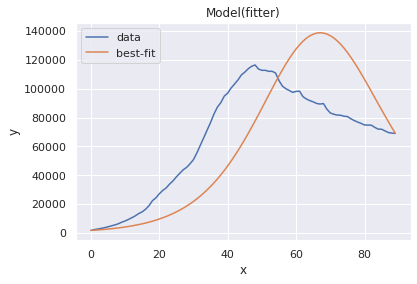

In [285]:
model = SIROneStain(population)

subset = df[20:110]
model.fit(subset, subset['infected'])

result = model.fit_result_
result.plot_fit(datafmt="-");
result

In [281]:
S, I, R = model.predict(subset)

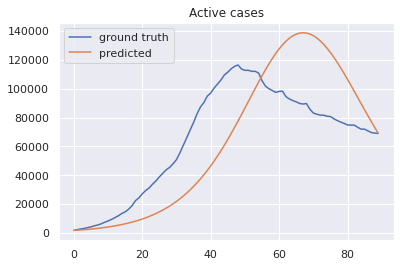

In [282]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

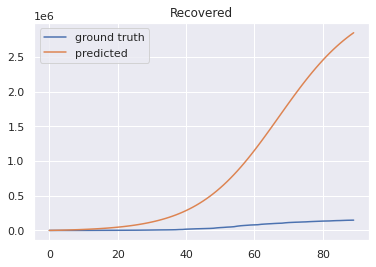

In [283]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

## SEIR first peak

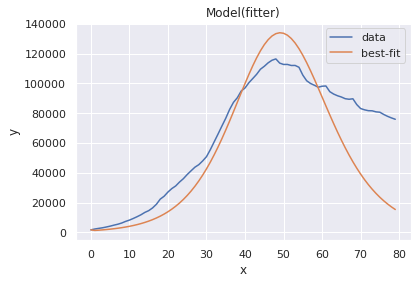

In [294]:
model = SEIROneStain(population)

subset = df.iloc[20:100]
model.fit(subset, subset['infected'])

result = model.fit_result_
result.plot_fit(datafmt="-");

In [295]:
result.best_values

{'beta': 2.128871761082818,
 'gamma': 0.8766427686000391,
 'delta': 0.9999999999999996}

In [297]:
S, E, I, R = model.predict(subset)

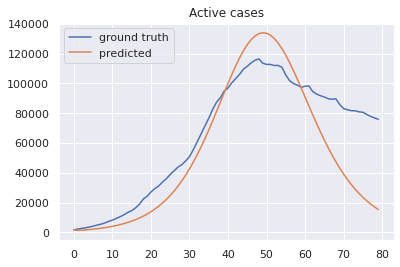

In [298]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

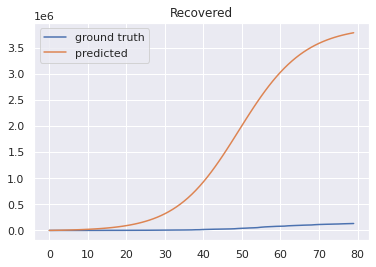

In [299]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

# Evaluate predictive ability

In [300]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

In [301]:
tscv = TimeSeriesSplit(n_splits=5,
                       max_train_size=50)

Fold 0
50 51
Train MAE: 5359.88


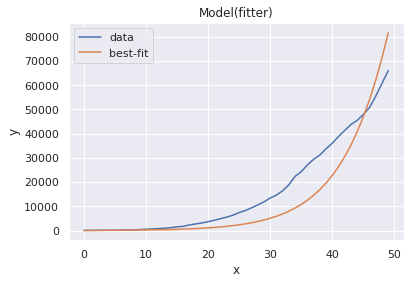

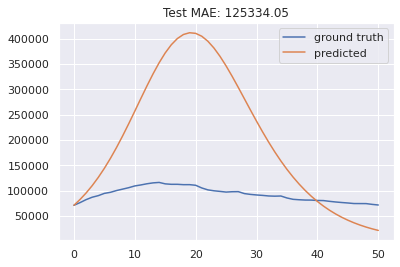

Fold 1
50 51
Train MAE: 7821.70


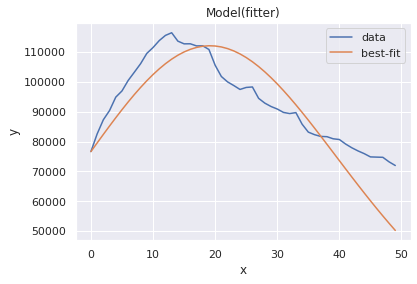

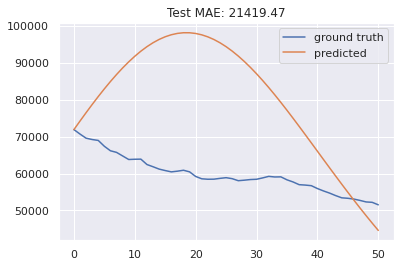

Fold 2
50 51
Train MAE: 10521.69


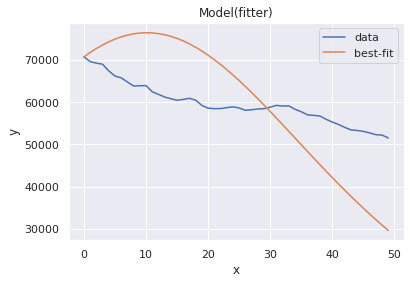

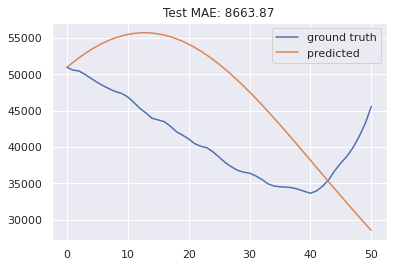

Fold 3
50 51
Train MAE: 5553.69


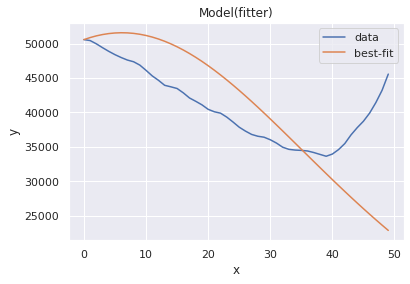

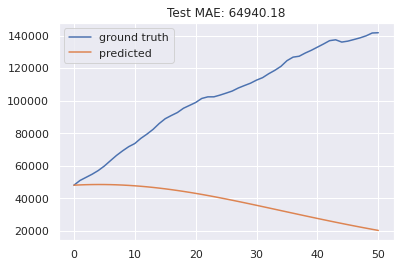

Fold 4
50 51
Train MAE: 15312.97


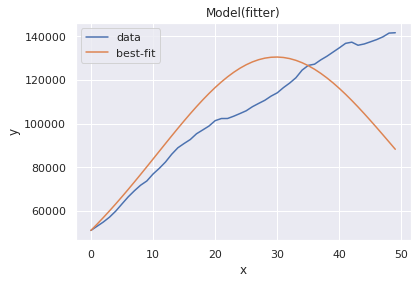

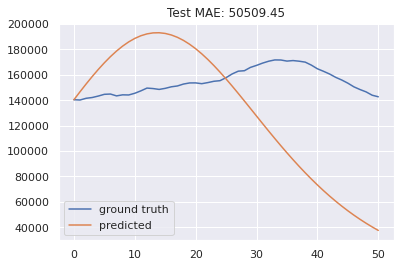

In [302]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset, train_subset['infected'])

    result = model.fit_result_
    params.append(result.best_values)
    result.plot_fit(datafmt="-")

    S, I, R = model.predict(test_subset)
    
    train_mae = mean_absolute_error(result.best_fit, train_subset['infected'])
    print(f'Train MAE: {train_mae:0.2f}')
    
    mae = mean_absolute_error(I, test_subset['infected'])
    maes.append(mae)
    
    plt.figure()
    plt.plot(test_t, test_subset['infected'], label='ground truth')
    plt.plot(test_t, I, label='predicted')
    plt.title(f'Test MAE: {mae:0.2f}')
    plt.legend()
    plt.show()

In [303]:
params

[{'beta': 0.6529643902795509, 'gamma': 0.4999999999990874},
 {'beta': 0.5000000000000018, 'gamma': 0.4586512039424504},
 {'beta': 0.5000000000000089, 'gamma': 0.47583783076928576},
 {'beta': 0.5000000000000028, 'gamma': 0.4833132663890531},
 {'beta': 0.5000000000000001, 'gamma': 0.4315345533326552}]